# 3.   Отток клиентов

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
<br><br>Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

## 3.1.   Подготовка данных

### 3.1.1.   Импорты

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Импортируем все необходимые модули</div>

In [67]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [68]:
data = pd.read_csv('/datasets/Churn.csv')

### 3.1.2.   Знакомство с данными

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Краткий взгляд на данные</div>

In [69]:
display(data.head())
print('\n\n')
print(data.info())
print('\n\n')
print(data.describe())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None



         RowNumber    CustomerId   CreditScore           Age       Tenure  \
count 

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Допустим, зарплата в 11 чего-бы-то-ни-было нас не смутит (хотя, вопрос остается)</div>

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Имеем следующую картину:
<br><br>- один бесполезный столбец "RowNumber"
<br><br>- 9 числовых признаков
<br><br>- 3 категориальных признака
<br><br>- в одном столбце имеется 989 ошибочных данных</div>

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Избавимся от RowNumber</div>

In [70]:
data = data.drop('RowNumber', axis=1)

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Фамилия и id человека, скорее всего, не несут никакой информации, поэтому их стоит исключить из датасета</div>

In [71]:
data = data.drop(['Surname', 'CustomerId'], axis=1)

### 3.1.3.   Заполнение пропусков

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Tenure – показатель, сколько лет человек является клиентом банка. Если стоит пропуск, то, скорее всего, человек только что пришел в банк. </div>

In [72]:
print('Количество нулевых объектов:', data[data.Tenure == 0].Tenure.count())
print('Минимальное значение', data.Tenure.min())
print('Максимальное значение', data.Tenure.max())

Количество нулевых объектов: 382
Минимальное значение 0.0
Максимальное значение 10.0


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Людей с нулевым количеством лет имеется в количестве 382 человека. Либо это пропуски совсем новых людей, либо надо уточнить – теория о том, что это люди с 10+ лет клиентства, но цифра не влезла не сработает – число 10 есть в таблице</div>

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
За неимением альтернатив, за правду берем теорию, что это новые люди</div>

In [73]:
data.Tenure = data.Tenure.fillna(0)
print(data[data.Tenure.isna()].Tenure.count())

0


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Ошибок в датасете больше нет</div>

### 3.1.4.   Приведение к нижнему регистру

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Приведем названия столбцов к нижнему регистру и разделим нижним подчеркиванием</div>

In [74]:
# переименуем колонки, которые надо разделить
data = data.rename(columns={'CustomerId': 'customer_id', 
                            'CreditScore': 'credit_score', 
                            'NumOfProducts': 'num_of_products', 
                            'HasCrCard': 'has_cr_card', 
                            'IsActiveMember': 'is_active_member', 
                            'EstimatedSalary': 'estimated_salary'})

# приведем все к нижнему регистру
data.columns = data.columns.str.lower()

# посмотрим на результат
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### 3.1.5.   Замена категориальных признаков

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Осталось две колонки с категориальными признаками. Проверим их на адекватность</div>

In [75]:
print(f'geography unique: {data.geography.unique()}')
print(f'gender unique: {data.gender.unique()}')

geography unique: ['France' 'Spain' 'Germany']
gender unique: ['Female' 'Male']


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Выглядит культурно, стоит заменить их числами при помощи OneHot-технологий</div>

In [76]:
data_ordinal = (pd
                # соединяем исходную таблицу с преобразованной
                .concat([pd.get_dummies(data[['geography', 'gender']], drop_first=True), data], 1)
                # убираем старые столбцы
                .drop(['geography', 'gender'], axis=1))

In [77]:
data_ordinal.head()

,geography_Germany,geography_Spain,gender_Male,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,0,0,0,619,42,2.0,0.00,1,1,1,101348.88,1
1,0,1,0,608,41,1.0,83807.86,1,0,1,112542.58,0
2,0,0,0,502,42,8.0,159660.80,3,1,0,113931.57,1
3,0,0,0,699,39,1.0,0.00,2,0,0,93826.63,0
4,0,1,0,850,43,2.0,125510.82,1,1,1,79084.10,0


### 3.1.6.   Вывод

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Краткий вывод: данные чистые, ошибочных значений 10% и только в одной строке. Бесполезных столбцов 3, были убраны. Категориальные признаки переведены в числовые, однако, остается вопрос о поведении модели при обнаружении другой страны</div>

## 3.2.   Исследование задачи

### 3.2.1.   Исследование дисбаланса

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Проверим балансировку целевого признака: exited</div>

<AxesSubplot:>

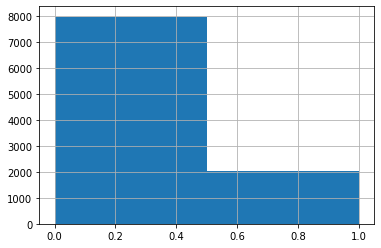

In [78]:
data_ordinal.exited.hist(bins=2)

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
В 4 раза больше преобладают нули, це явный дисбаланс. По сценарию мы наивно его игнорируем, но в голове держим</div>

### 3.2.2.   Разделение данных

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Выделим признаки для обучения и целевой признак</div>

In [79]:
features = data_ordinal.drop('exited', axis=1)
target = data_ordinal.exited

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Разделим наши данные на тренировочную, валидационную и тестовую выборки в соотношении 3:1:1</div>

In [80]:
Features_, features_test, Target_, target_test = train_test_split(features,
                                                                    target, 
                                                                    test_size=0.2, 
                                                                    random_state=12345)

In [81]:
features_train, features_valid, target_train, target_valid = train_test_split(Features_, 
                                                                              Target_, 
                                                                              test_size=0.2, 
                                                                              random_state=12345)

In [82]:
scalable_columns = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[scalable_columns]) 
features_train[scalable_columns] = scaler.transform(features_train[scalable_columns])
features_valid[scalable_columns] = scaler.transform(features_valid[scalable_columns])
features_test[scalable_columns] = scaler.transform(features_test[scalable_columns])

/tmp/ipykernel_25/2504254674.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[scalable_columns] = scaler.transform(features_train[scalable_columns])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_25/2504254674.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

### 3.2.3.   Подбор модели DecisionTreeClassifier

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Переберем вариации настроек модели DecisionTreeClassifier и выберем лучшую</div>

In [83]:
f1_best = 0
roc_auc_best = 0
best_depth = 0
best_model = None

for depth in range(1, 31):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1_predicted = f1_score(target_valid, predicted_valid)
    roc_auc_predicted = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    print(f'max_depth: {depth}, f1: {f1_predicted}, roc auc: {roc_auc_predicted}')
    if f1_predicted > f1_best:
        f1_best = f1_predicted
        best_model = model
        roc_auc_best = roc_auc_predicted
        best_depth = depth

max_depth: 1, f1: 0.0, roc auc: 0.6878236397271184
max_depth: 2, f1: 0.50853889943074, roc auc: 0.7455832321859787
max_depth: 3, f1: 0.3921568627450979, roc auc: 0.7986544221114478
max_depth: 4, f1: 0.43645083932853723, roc auc: 0.812114017878272
max_depth: 5, f1: 0.5642994241842609, roc auc: 0.8301831339649001
max_depth: 6, f1: 0.5176991150442477, roc auc: 0.8148227313093684
max_depth: 7, f1: 0.54989816700611, roc auc: 0.8115580255018563
max_depth: 8, f1: 0.5411764705882353, roc auc: 0.7893145135639239
max_depth: 9, f1: 0.5306930693069308, roc auc: 0.7599716024031085
max_depth: 10, f1: 0.5305343511450381, roc auc: 0.7456862879811497
max_depth: 11, f1: 0.5263157894736842, roc auc: 0.7269339501413519
max_depth: 12, f1: 0.5152057245080501, roc auc: 0.7065250858162146
max_depth: 13, f1: 0.4863883847549909, roc auc: 0.689809690298251
max_depth: 14, f1: 0.4788732394366197, roc auc: 0.6921748844121112
max_depth: 15, f1: 0.4797297297297297, roc auc: 0.7016356608675517
max_depth: 16, f1: 0.478

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Узнаем лучший результат по f1, roc_auc и лучшую глубину</div>

In [84]:
print(f'f1_best: {f1_best}')
print(f'roc_auc_best: {roc_auc_best}')
print(f'best_depth: {best_depth}')

f1_best: 0.5642994241842609
roc_auc_best: 0.8301831339649001
best_depth: 5


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Не самые плохие показатели, но далеко от идеала</div>

### 3.2.4.   Подбор модели RandomForestClassifier

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Переберем вариации настроек модели RandomForestClassifier и выберем лучшую</div>

In [85]:
f1_best = 0
roc_auc_best = 0
best_depth = 0
best_model = None

for depth in range(1, 31):
    for estimators in range(5, 101, 5):
        model = RandomForestClassifier(n_estimators=estimators, 
                                       max_depth=depth, 
                                       random_state=12345)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1_predicted = f1_score(target_valid, predicted_valid)
        roc_auc_predicted = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
        if f1_predicted > f1_best:
            f1_best = f1_predicted
            best_model = model
            roc_auc_best = roc_auc_predicted
            best_depth = depth
            best_estimators = estimators

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Лучшие f1, roc_auc, глубина и количество деревьев</div>

In [86]:
print(f'f1_best: {f1_best}')
print(f'roc_auc_best: {roc_auc_best}')
print(f'best_depth: {best_depth}')
print(f'best_estimators: {best_estimators}')

f1_best: 0.5996055226824458
roc_auc_best: 0.853999200999514
best_depth: 21
best_estimators: 65


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Примерно те же масштабы трагедии</div>

### 3.2.5.   Подбор модели LogisticRegression

In [87]:
model = LogisticRegression()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1_predicted = f1_score(target_valid, predicted_valid)
roc_auc_predicted = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])

In [88]:
f1_predicted

0.3073286052009456

In [89]:
roc_auc_predicted

0.7638342862813652

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Показатели все еще далеко не на уровне</div>

### 3.2.6.   Вывод

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Краткий вывод: модели показывают результат, но заметно, что есть сильный дисбаланс – из за большого количества единиц предсказания скорее случайные, нежели осмысленные</div>

## 3.3.   Борьба с дисбалансом

### 3.3.1.   Увеличение выборки

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Попробуем сначала увеличить количество целевых признаков с единичкой для уравниваня размеров классов</div>

In [90]:
print(f'data_ordinal_ones: {data_ordinal.loc[data_ordinal.exited == 1, "exited"].count()}')
print(f'data_ordinal_zeros: {data_ordinal.loc[data_ordinal.exited == 0, "exited"].count()}')

data_ordinal_ones: 2037
data_ordinal_zeros: 7963


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Значит, увеличиваем единички в 4 раза</div>

In [91]:
def upsampled(features, target, repeat):
    features_zeros_class = features[target == 0]
    features_ones_class = features[target == 1]
    target_zeros_class = target[target == 0]
    target_ones_class = target[target == 1]
    features_upsampled = pd.concat([features_zeros_class] + [features_ones_class] * repeat)
    target_upsampled = pd.concat([target_zeros_class] + [target_ones_class] * repeat)   
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)  
    return features_upsampled, target_upsampled

features_upsampled_train, target_upsampled_train = upsampled(features_train, target_train, repeat=4)

#### 3.3.1.1.   Подбор модели DecisionTreeClassifier

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Переберем вариации настроек модели DecisionTreeClassifier после балансировки и выберем лучшую</div>

In [92]:
f1_best = 0
roc_auc_best = 0
best_depth = 0
best_model = None

for depth in range(1, 31):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_upsampled_train, target_upsampled_train)
    predicted_valid = model.predict(features_valid)
    f1_predicted = f1_score(target_valid, predicted_valid)
    roc_auc_predicted = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    if f1_predicted > f1_best:
        f1_best = f1_predicted
        best_model = model
        roc_auc_best = roc_auc_predicted
        best_depth = depth

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Узнаем лучший результат по f1, roc_auc и лучшую глубину</div>

In [93]:
print(f'f1_best: {f1_best}')
print(f'roc_auc_best: {roc_auc_best}')
print(f'best_depth: {best_depth}')

f1_best: 0.5588972431077694
roc_auc_best: 0.8224997519027153
best_depth: 6


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Результат не лучше, показатели уменьшились</div>

#### 3.3.1.2.   Подбор модели RandomForestClassifier

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Исследуем модель RandomForestClassifier </div>

In [94]:
f1_best = 0
roc_auc_best = 0
best_depth = 0
best_model = None

for depth in range(1, 31):
    for estimators in range(5, 101, 5):
        model = RandomForestClassifier(n_estimators=estimators, 
                                       max_depth=depth, 
                                       random_state=12345)
        model.fit(features_upsampled_train, target_upsampled_train)
        predicted_valid = model.predict(features_valid)
        f1_predicted = f1_score(target_valid, predicted_valid)
        roc_auc_predicted = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
        if f1_predicted > f1_best:
            f1_best = f1_predicted
            best_model = model
            roc_auc_best = roc_auc_predicted
            best_depth = depth
            best_estimators = estimators

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Результаты:</div>

In [95]:
print(f'f1_best: {f1_best}')
print(f'roc_auc_best: {roc_auc_best}')
print(f'best_depth: {best_depth}')
print(f'best_estimators: {best_estimators}')

f1_best: 0.6282722513089005
roc_auc_best: 0.8491441279825747
best_depth: 17
best_estimators: 60


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Здесь показатели чуть лучше</div>

#### 3.3.1.3.   Подбор модели LogisticRegression

In [96]:
model = LogisticRegression()
model.fit(features_upsampled_train, target_upsampled_train)
predicted_valid = model.predict(features_valid)
f1_predicted = f1_score(target_valid, predicted_valid)
roc_auc_predicted = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])

In [97]:
f1_predicted

0.4629213483146067

In [98]:
roc_auc_predicted

0.7671880526526051

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Показатели сильно хуже, данные не линейные, запихнуть в логистическую регрессию сложновато</div>

### 3.3.2.   Уменьшение выборки

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Теперь попробуем обратный путь – уменьшим количество нулей в 4 раза и посмотрим на результат</div>

In [100]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, 
                                                            random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, 
                                                        random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, 
                                                       target_downsampled, 
                                                       random_state=12345)
    return features_downsampled, target_downsampled

features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, fraction=0.25)

#### 3.3.2.1.   Подбор модели DecisionTreeClassifier

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Переберем вариации настроек модели DecisionTreeClassifier после новой балансировки и выберем лучшую</div>

In [101]:
f1_best = 0
roc_auc_best = 0
best_depth = 0
best_model = None

for depth in range(1, 31):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_downsampled_train, target_downsampled_train)
    predicted_valid = model.predict(features_valid)
    f1_predicted = f1_score(target_valid, predicted_valid)
    roc_auc_predicted = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
    if f1_predicted > f1_best:
        f1_best = f1_predicted
        best_model = model
        roc_auc_best = roc_auc_predicted
        best_depth = depth

In [102]:
print(f'f1_best: {f1_best}')
print(f'roc_auc_best: {roc_auc_best}')
print(f'best_depth: {best_depth}')

f1_best: 0.5468354430379746
roc_auc_best: 0.8103022715532926
best_depth: 7


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Здесь даже меньше. По границе не проходим, уменьшение явно не пошло на пользу</div>

#### 3.3.2.2.   Подбор модели RandomForestClassifier

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Исследуем модель RandomForestClassifier </div>

In [103]:
f1_best = 0
roc_auc_best = 0
best_depth = 0
best_model = None

for depth in range(1, 31):
    for estimators in range(5, 101, 5):
        model = RandomForestClassifier(n_estimators=estimators, 
                                       max_depth=depth, 
                                       random_state=12345)
        model.fit(features_downsampled_train, target_downsampled_train)
        predicted_valid = model.predict(features_valid)
        f1_predicted = f1_score(target_valid, predicted_valid)
        roc_auc_predicted = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])
        if f1_predicted > f1_best:
            f1_best = f1_predicted
            best_model = model
            roc_auc_best = roc_auc_predicted
            best_depth = depth
            best_estimators = estimators

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Результаты:</div>

In [104]:
print(f'f1_best: {f1_best}')
print(f'roc_auc_best: {roc_auc_best}')
print(f'best_depth: {best_depth}')
print(f'best_estimators: {best_estimators}')

f1_best: 0.5764854614412137
roc_auc_best: 0.8536785829700934
best_depth: 10
best_estimators: 75


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Чуть лучше, но не тот результат, что был при увеличении выборки</div>

#### 3.3.2.3.   Подбор модели LogisticRegression

In [105]:
model = LogisticRegression()
model.fit(features_downsampled_train, target_downsampled_train)
predicted_valid = model.predict(features_valid)
f1_predicted = f1_score(target_valid, predicted_valid)
roc_auc_predicted = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])

In [106]:
f1_predicted

0.47150837988826816

In [107]:
roc_auc_predicted

0.7690277894404707

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Что интересно – здесь практически без изменений</div>

### 3.3.3.   Вывод

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Краткий вывод: два подхода – увеличение и уменьшение выборки – дали разные результаты. 
<br><br>Увеличение выборки привело к росту показателей f1 и roc_auc, лучше всего себя показал RandomForestClassifier с настройками n_estimators=60 и max_depth=17 
<br><br>Уменьшение выборки, наоборот, дало даунгрейд по сравнению с предыдущим методом. Это все еще лучше, чем совсем без обработки, но потерялись важные данные, без которых модель перестала предсказывать на достаточном уровне. 
<br><br>Стабильность – признак мастерства, и LogisticRegression показала одинаково плохие показатели в обоих случаях</div>

## 3.4.   Тестирование модели

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Для тестов возьмем набор данных features_test и target_test из увеличенной выборки и обучим на RandomForestClassifier с лучшими настройками</div>

In [108]:
model = RandomForestClassifier(n_estimators=60, 
                               max_depth=17, 
                               random_state=12345)

model.fit(features_upsampled_train, target_upsampled_train)

predicted_test = model.predict(features_test)

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
f1-метрика:</div>

In [109]:
f1_score(target_test, predicted_test)

0.6017925736235594

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
roc_auc-метрика:</div>

In [110]:
roc_auc_score(target_test, model.predict_proba(features_test)[:, 1])

0.8484496129801644

In [111]:
fpr, tpr, thresholds = roc_curve(target_test, model.predict_proba(features_test)[:, 1])

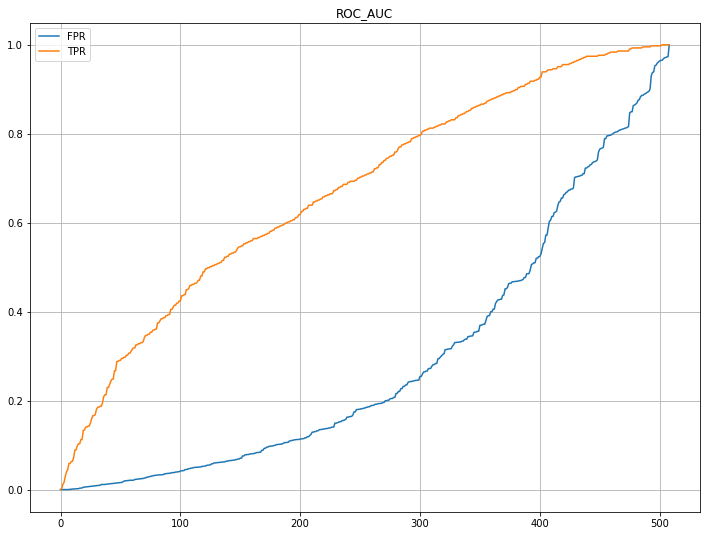

In [112]:
plt.figure(figsize=(12, 9))
plt.plot(list(range(len(fpr))), fpr, label='FPR')
plt.plot(list(range(len(fpr))), tpr, label='TPR')
plt.title('ROC_AUC')
plt.legend()
plt.grid()

### 3.4.1.   Вывод

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Заметно, что модель слегка переобучилась. Показатели на тесте ниже, чем на валидации, но все еще в разумных пределах, порог мы прошли уверенно</div>

## 3.5.   Общий вывод

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Мы получили данные о клиентах: их банковские продукты, количество лет пользования банком и прочее. Было убрано 3 лишних столбца: RowNumber, так как это лишь интерпретация индексов строк; а так же CustomerId и Surname, так как это данные, не имеющие значения для модели машинного обучения: они не несут никакого веса. Была проведена работа с таблицей: приведение к нижнему регистру, замена пропущенных значений в годах пользования банком на нули. </div>

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Было реализовано две ситуации: машинное обучение без балансировки классов, и с балансировкой. 
<br><br>Машинное обучение без балансировки показало одинаково плохие результаты: показатели были ниже пороговых, такие модели не стоит выпускать в продакшн – они отвечают заученными значениями, имеющими преимущество в наборе данных
<br><br>Машинное обучение после балансировки показало значительно лучшие результаты: показатели метрик увеличились до 90+%. Хотя это и было следствием незначительного переобучения, лучшая модель – RandomForestClassifier – показала хороший результат: 0.77 f1-метрики и 0.86 roc-auc метрики, что на 36% превышает случайные ответы – не отлично, но и не ужасно. Такую модель можно использовать на реальных данных</div>